# Business performance analysis of Procrastinate Pro+ app

1. [Importing libraries and dataset](#start)
    * [Data preprocessing](#prep)
    * [Summary](#summary_start)   
2. [Functions for calculating and analyzing LTV, ROI, retention and conversion](# funcs)
3. [EDA](#eda)
    * [User profiles](#user_profiles)
    * [Regions analysis](#regions)
    * [Devices analysis](#devices)
    * [Channels analysis](#channels)
    * [Summary](#sum_eda)
4. [Marketing](#marketing)
    * [Acquisition cost](#costs)
    * [Average CAC per user](#cac)
    * [Summary](#sum_marketing)
5. [Return on advertising](#return)
    * [Total return on advertising](#total_return)
    * [Return on advertising by devices](#device_return)
    * [Return on advertising by ad channels](#channel_return)
    * [Return on advertising by countries](#region_return)
    * [Summary](#sum_return)
6. [Conversion and retention](#conversion_retention)
    * [Conversion and retention by devices](#device_conversion_retention)
    * [Conversion and retention by countries](#region_conversion_retention)
    * [Conversion and retention by ad channels](#channel_conversion_retention)
7. [Conclusion](#conclusion)

<a id="start"></a>
## Importing libraries and dataset

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', '{:,.2f}'.format)

Download the provided data, convert it to a `DataFrame` using `pandas`. We will output information about the dataset and its first 5 rows.

In [2]:
visits = pd.read_csv('visits_info_short.csv')
display(visits.info())
display(visits.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


`visits_info_short.csv`
* `User Id` - unique user ID,
* `Region` - user's country,
* `Device` - user device type,
* `Channel` - transition source ID,
* `Session Start` - date and time of the session start,
* `Session End` - date and time of the end of the session.

For more convenient handling, change the case of the column names and rename some of them

In [3]:
visits.columns = [x.lower() for x in visits.columns]
visits = visits.rename(columns={'user id': 'user_id', 'session start': 'session_start', 'session end': 'session_end'})

In [4]:
orders = pd.read_csv('orders_info_short.csv')
display(orders.info())
display(orders.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


`orders_info_short.csv`
* `User Id` - unique user ID,
* `Event Dt` - date and time of purchase,
* `Revenue` - revenue of order.

Rename columns

In [5]:
orders.columns = [x.lower() for x in orders.columns]
orders = orders.rename(columns={'user id': 'user_id', 'event dt': 'event_dt'})

In [6]:
costs = pd.read_csv('costs_info_short.csv')
display(costs.info())
display(costs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.30
1,2019-05-02,FaceBoom,78.10
2,2019-05-03,FaceBoom,85.80
3,2019-05-04,FaceBoom,136.40
4,2019-05-05,FaceBoom,122.10


`costs_info_short.csv`
* `Channel` - advertising campaign name,
* `Dt` - date of the advertising campaign,
* `Costs` - the cost of this campaign.

In [7]:
costs.columns = [x.lower() for x in costs.columns]

<a id="prep"></a>
### Data preprocessing

Change the data type in columns

In [8]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

orders['event_dt'] = pd.to_datetime(orders['event_dt'])

costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

Check data for duplicates

In [9]:
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


Check datasets for missing values

In [10]:
round((visits.isna().mean()*100),2)

user_id         0.00
region          0.00
device          0.00
channel         0.00
session_start   0.00
session_end     0.00
dtype: float64

In [11]:
round((orders.isna().mean()*100),2)

user_id    0.00
event_dt   0.00
revenue    0.00
dtype: float64

In [12]:
round((costs.isna().mean()*100),2)

dt        0.00
channel   0.00
costs     0.00
dtype: float64

<a id="summary_start"></a>
### Summary
* Changed the case of the column names and renamed some columns
* Changed date data type to `datetime`
* Checked for duplicates and missing values

<a id="funcs"></a>
## Functions for calculating and analyzing LTV, ROI, retention and conversion

#### get_profiles() - function to create user profiles

In [13]:
def get_profiles(sessions, orders, ad_costs):
    # find the parameters of the first visits
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    # for cohort analysis, we determine the date of the first visit
    # and the first day of the month in which this visit occurred
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    # add a sign of paying users
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    # counting the number of unique users
    # with the same source and date of attraction
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    # combine advertising costs and the number of attracted users
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    # divide advertising costs by the number of attracted users
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    # adding acquisition cost to profiles
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    # the cost of organic user acquisition is zero
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    return profiles

#### get_retention() - function to calculate retention

In [14]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    # add the payeer column to the passed dimensions list
    dimensions = ['payer'] + dimensions
    # we exclude users who did not "survive" to the observation horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # collecting "raw" data to calculate retention
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days
    # function for grouping a table according to the desired features
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    # get retention table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    # get table of retention dynamics
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    return result_raw, result_grouped, result_in_time

#### get_conversion() - function for calculating conversion

In [15]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    # we exclude users who did not "survive" to the observation horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # determine the date and time of the first purchase for each user
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )
    # adding purchase data to profiles
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )
    # calculate lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # group by cohort if there is nothing in dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']
    # function for grouping a table according to the desired features
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # divide each "cell" in the row by the size of the cohort
        # and get a conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    # get conversion table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    # for the conversion dynamics table, remove 'cohort' from dimensions
    if 'cohort' in dimensions: 
        dimensions = []
    # get a table of conversion dynamics
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    return result_raw, result_grouped, result_in_time

#### get_ltv() - function for calculating LTV and ROI

In [16]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    # we exclude users who did not "survive" to the observation horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # adding purchase data to profiles
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # calculate lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
   # group by cohort if there is nothing in dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    # function for grouping a table according to the desired features
    def group_by_dimensions(df, dims, horizon_days):
        # we build a "triangular" revenue table
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # calculate the revenue with accumulation
        result = result.fillna(0).cumsum(axis=1)
        # calculate cohort sizes
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # merge cohort sizes and revenue table
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # calculate LTV: divide each “cell” in the row by the size of the cohort
        result = result.div(result['cohort_size'], axis=0)
        # exclude all lifetimes that exceed the analysis horizon
        result = result[['cohort_size'] + list(range(horizon_days))]
        # restore cohort sizes
        result['cohort_size'] = cohort_sizes
        # we assemble a dataframe with user data and CAC values, 
        # adding parameters from dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        # we calculate the average CAC by parameters from dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        # calculate ROI: divide LTV by CAC
        roi = result.div(cac['cac'], axis=0)
        # remove rows with infinite ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        # restore cohort sizes in the ROI table
        roi['cohort_size'] = cohort_sizes
        # add CAC to ROI table
        roi['cac'] = cac['cac']
        # in the final table we have the sizes of cohorts, CAC
        # and ROI in lifetimes that do not exceed the analysis horizon
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    # for dynamics tables remove 'cohort' from dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # get tables of LTV and ROI dynamics
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    return (
        result_raw,
        result_grouped,  # LTV
        result_in_time,  # LTV dynamics
        roi_grouped,  # ROI
        roi_in_time,  # ROI dynamics
    )

#### filter_data() - frame filtering function

In [17]:
def filter_data(df, window):
    # for each column apply a moving mean
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

#### plot_retention() - function to visualize retention

In [18]:
def plot_retention(retention, retention_history, horizon, window=7):
    plt.figure(figsize=(15, 10))
    # exclude cohort sizes and first day retention
    retention = retention.drop(columns=['cohort_size', 0])
    # in the table of dynamics we leave only the necessary lifetime
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]
    # if there is only payeer in the hold table indexes,
    # add the second feature - cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])
    # in the first graph, the retention curves of paying users
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of paying users')
    # in the second graph, retention curves for non-payers
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of non-payers')
    # in the third graph, the dynamics of retention of paying
    ax3 = plt.subplot(2, 2, 3)
    # get column names for pivot table
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # filtering data and plotting
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition date')
    plt.title(
        'Dynamics of retention of paying users on the {}-th day'.format(
            horizon
        )
    )
    # in the forth graph, the dynamics of retention of non-paying
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Acquisition date')
    plt.title(
        'Dynamics of retention of non-paying users on the {}-th day'.format(
            horizon
        )
    )
  
    plt.tight_layout()
    plt.show()

#### plot_conversion() - function to visualize the conversion

In [19]:
def plot_conversion(conversion, conversion_history, horizon, window=7):
    plt.figure(figsize=(15, 5))
    # exclude cohort sizes
    conversion = conversion.drop(columns=['cohort_size'])
    # in the table of dynamics we leave only the necessary lifetime
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]
    # first graph - conversion curves
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Users conversion')
    # the second graph is the dynamics of conversion
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition date')
    plt.title('Dynamics of user conversion on the {}-th day'.format(horizon))

    plt.tight_layout()
    plt.show()

#### plot_ltv_roi() - function to visualize LTV and ROI

In [20]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
    plt.figure(figsize=(20, 10))
    # we exclude cohort sizes from the ltv table
    ltv = ltv.drop(columns=['cohort_size'])
    # in the ltv dynamics table we leave only the necessary lifetime
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    # write the cost of attraction in a separate frame
    cac_history = roi_history[['cac']]
    # from the table roi we exclude the sizes of cohorts and cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # in the roi dynamics table, we leave only the necessary lifetime
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]
    # first graph - ltv curves
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')
    # the second graph is the dynamics of ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition date')
    plt.title('Users LTV dynamics on the {} day'.format(horizon))
    # the third graph is the dynamics of cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition date')
    plt.title('User Acquisition Cost Dynamics')
    # fourth graph - roi curves
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')
    # the fifth graph is the dynamics of roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Acquisition date')
    plt.title('Dynamics of ROI of users on the {}-th day'.format(horizon))

    plt.tight_layout()
    plt.show()

<a id="eda"></a>
## EDA

<a id="user_profiles"></a>
### User profiles

In [21]:
profiles = get_profiles(visits, orders, costs)
profiles.head() 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.09
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.11
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.00
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.99
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.23


Let's determine the minimum and maximum dates for attracting users.

In [22]:
print('Minimum user acquisition date -', profiles['first_ts'].dt.date.min())
print('Maximum user acquisition date -', profiles['first_ts'].dt.date.max())

Minimum user acquisition date - 2019-05-01
Maximum user acquisition date - 2019-10-27


<a id="regions"></a>
### Regions analysis 

Let's find out from which countries users come to the app and which country accounts for the most paying users

In [23]:
table = profiles.pivot_table(index=['region'], columns='payer', values='user_id', aggfunc=['nunique'], margins=True)
table.columns = ['non_payers', 'payers', 'all_users']
table['precentage_payers_region'] = table['payers'] / table['all_users'] * 100
table[['all_users', 'precentage_payers_region']].sort_values(by='precentage_payers_region', ascending=False).drop(['All'], axis=0)

,all_users,precentage_payers_region
region,,
United States,100002,6.90
Germany,14981,4.11
UK,17575,3.98
France,17450,3.80


According to the table, we see that there are the most users from the USA, and the largest percentage of those paying from the USA (7%). The least paying in France (4%)

Overall, approximately 6% of users from all countries who pay

<a id="devices"></a>
### Devices analysis
Find out which devices are used by customers and which devices are preferred by paying users.

In [24]:
table = profiles.pivot_table(index=['device'], columns='payer', values='user_id', aggfunc=['nunique'], margins=True)
table.columns = ['non_payers', 'payers', 'all_users']
table['precentage_payers_device'] = table['payers'] / table['all_users'] * 100
table[['all_users', 'precentage_payers_device']].sort_values(by='precentage_payers_device', ascending=False).drop(['All'], axis=0)

,all_users,precentage_payers_device
device,,
Mac,30042,6.36
iPhone,54479,6.21
Android,35032,5.85
PC,30455,5.05


The largest share of paying users among iOS users - iPhone - 6.2%, Mac - 6.4%.

Among computer (PC) users, the least paying is 5%.

<a id="channels"></a>
### Channels analysis
Let's study the advertising sources of attraction and determine the channels from which the most paying users came.

In [25]:
table = profiles.pivot_table(index=['channel'], columns='payer', values='user_id', aggfunc=['nunique'], margins=True)
table.columns = ['non_payers', 'payers', 'all_users']
table['precentage_payers_channel'] = table['payers'] / table['all_users'] * 100
table[['all_users', 'precentage_payers_channel']].sort_values(by='precentage_payers_channel', ascending=False).drop(['All'], axis=0)

,all_users,precentage_payers_channel
channel,,
FaceBoom,29144,12.20
AdNonSense,3880,11.34
lambdaMediaAds,2149,10.47
TipTop,19561,9.60
RocketSuperAds,4448,7.91
WahooNetBanner,8553,5.30
YRabbit,4312,3.83
MediaTornado,4364,3.57
LeapBob,8553,3.06


Most of the paying users come from FaceBoom advertising channels (12%), AdNonSense (11%), lambdaMediaAds (10%)

Least of all organically - 2%, but free of charge

<a id="sum_eda"></a>
### Summary
* The largest number of users from the USA, among them the largest share of paying. The lowest proportion of those paying in France
* The most paying users use iOS devices, the least among PC users
* The organic channel receives the least number of customers who pay at the same time. Most of the paying users come from FaceBoom advertising channels (12%), AdNonSense (11%), lambdaMediaAds (10%)

<a id="marketing"></a>
## Marketing

<a id="costs"></a>
### Acquisition cost
Let's calculate the total amount of marketing expenses

In [26]:
print('Total amount of acquisition costs:', int(profiles['acquisition_cost'].sum()))

Total amount of acquisition costs: 105497


**Costs are distributed by ad channels** 

In [27]:
profiles.groupby('channel')[['acquisition_cost']].sum().sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,"54,751.30"
FaceBoom,"32,445.60"
WahooNetBanner,"5,151.00"
AdNonSense,"3,911.25"
OppleCreativeMedia,"2,151.25"
RocketSuperAds,"1,833.00"
LeapBob,"1,797.60"
lambdaMediaAds,"1,557.60"
MediaTornado,954.48


The cheapest (aka free) is an organic channel, which, as we found out earlier, brought the most paying users

According to the table, two expensive channels are distinguished - TipTop & FaceBoom. 

* TipTop takes a lot of money, but fewer customers came through it than through FaceBoom (TipTop is in third place in attracting the number of users). 
* FaceBoom leads only 88% of paying customers, however, in general, it is in second place in attracting users.

Because we do not pay for the organic channel, it was decided not to include it in the analysis.

In [28]:
profiles = profiles.query('channel != "organic"')

Display a graph of changes in time spent on marketing through channels

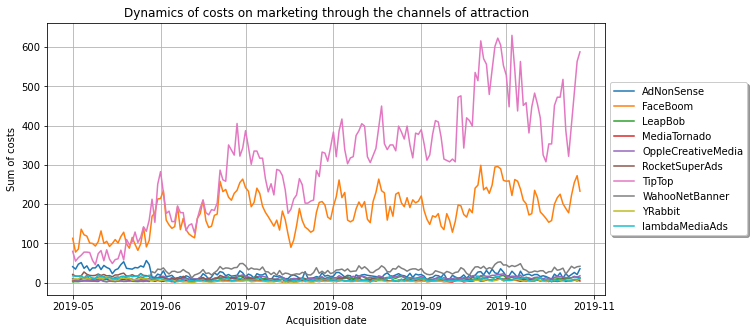

In [29]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='sum'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('Sum of costs')
plt.xlabel('Acquisition date')
plt.title('Dynamics of costs on marketing through the channels of attraction')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True, shadow=True)
plt.show()

The graph highlights large spendings on TipTop and FaceBoom channels, while on other channels costs are about the same

**Let's build a graph of changes in metrics over time**

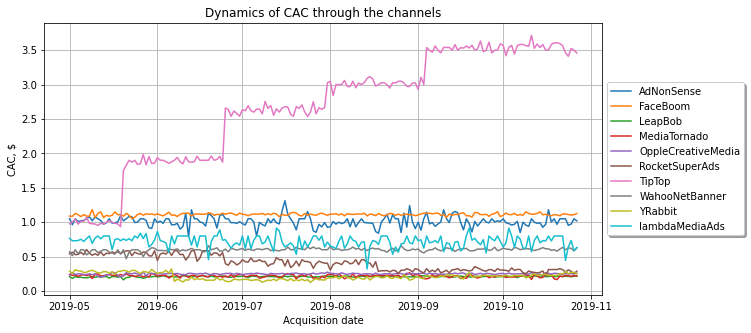

In [30]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Acquisition date')
plt.title('Dynamics of САС through the channels')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True, shadow=True)
plt.show()

According to the graph, we can see how the average costs for the TipTop channel grew. At the same time, the average CAC for FaceBoom has hardly changed during all this time

The average costs of other channels are distributed relatively evenly over time.

<a id="cac"></a>
### Average CAC per user
Let's calculate the average CAC per user for the entire project and for each traffic source.

In [31]:
# average CAC per user for the entire project
profiles['acquisition_cost'].mean()

1.127481323942928

In [32]:
# average CAC per user for each traffic source
profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean').sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


<a id="sum_marketing"></a>
### Summary
* Total marketing costs: 105,497
* The most expensive ad channel is TipTop (54,751 costs, FaceBoom is in second place with 32,446 costs)
* Average costs for TipTop have grown strongly over time
* Average CAC per user for the entire project - 1.13
* The average CAC across channels varies from 0.21 to 2.80. The average TipTop CAC is almost 3.0.

<a id="return"></a>
## Return on advertising
Let's build and analyze LTV, ROI and CAC graphs

We will assume that today is November 1, 2019, and the business plan says that users should pay off no later than two weeks after the attraction.

In [33]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

<a id="total_return"></a>
### Total return on advertising

In [34]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

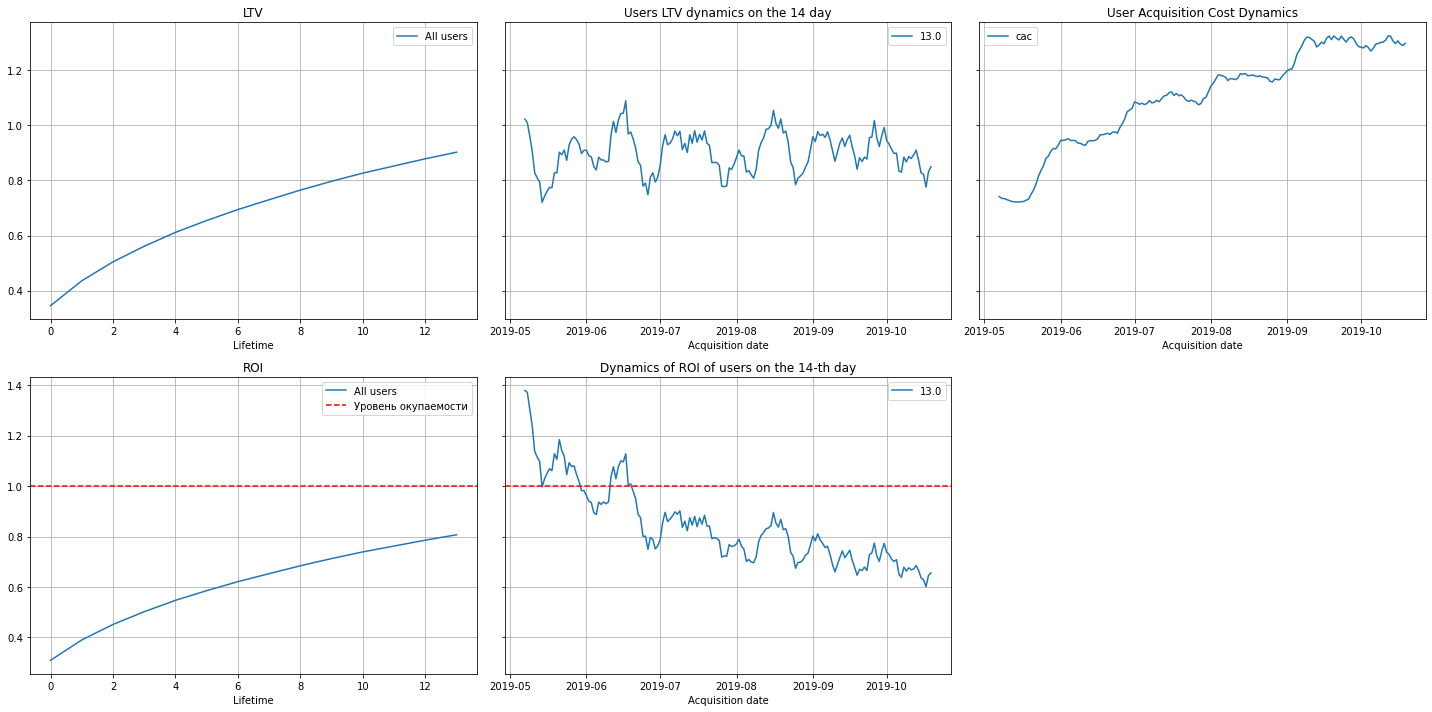

In [35]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

According to the graphs, we can make some conclusions:
1. Advertising doesn't pay off. The ROI at the end of the second week is slightly above 80%. The dynamics show that a strong decline in payback occurred in July and has been falling since then
2. CAC is unstable. Perhaps it's the increase in the advertising budget (which we also observed on the chart of the average CAC at the TipTop channel).
3. LTV is quite stable, but some cyclical dynamics are visible. We conclude that it's not about the deterioration of the quality of users.

It can be noted that the decline in payback correlates with an increase in advertising costs. Let's analyze the data in more detail.

<a id="device_return"></a>
### Return on advertising by devices

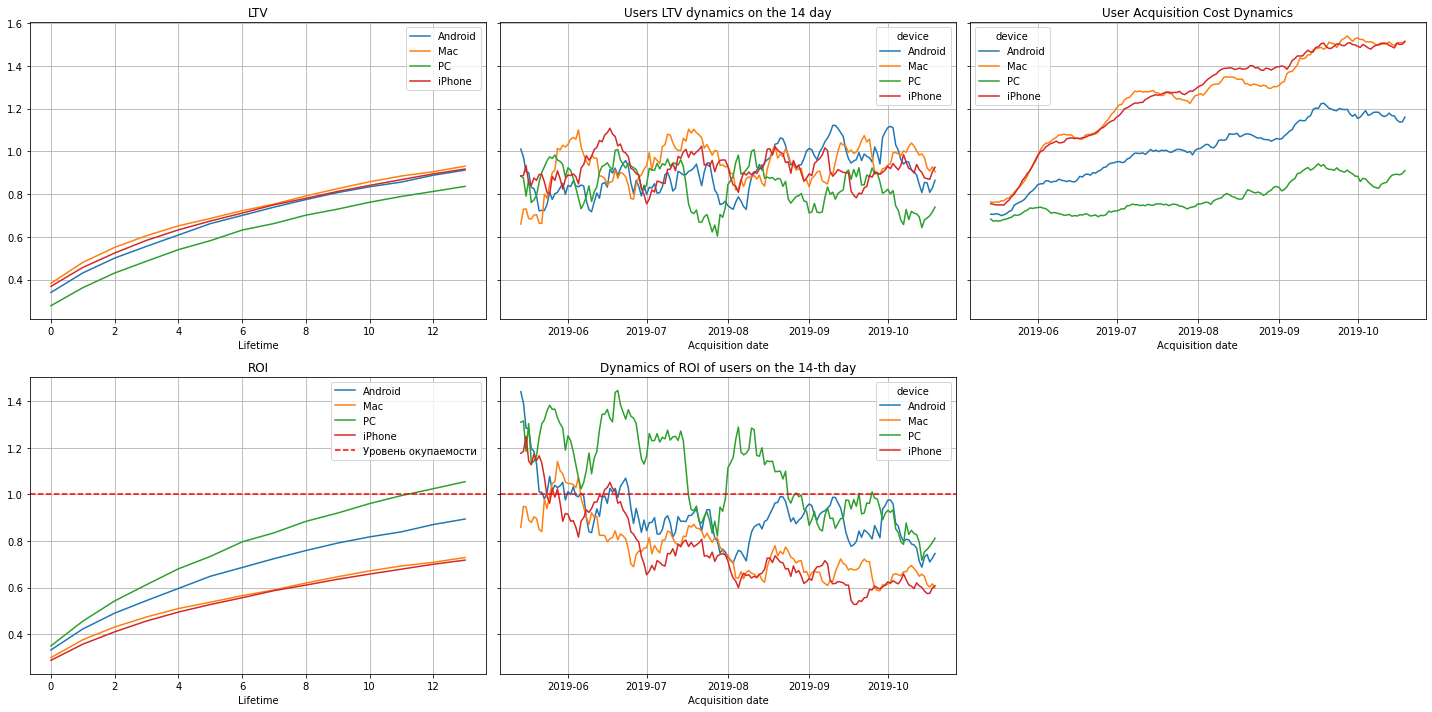

In [36]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Summary:
1. Advertising for almost all devices does not pay off, only for PCs after the 11th day the ROI is above 100%. The dynamics shows that for all devices except PC, the payback decline occurred in early July and has been falling since then. 
2. CAC is unstable. Growth across all devices, but for iPhone and Mac is stronger than for the rest.
3. LTV is quite stable and the same for all devices. It's not about the deterioration of the quality of users.

<a id="channel_return"></a>
### Return on advertising by ad channels

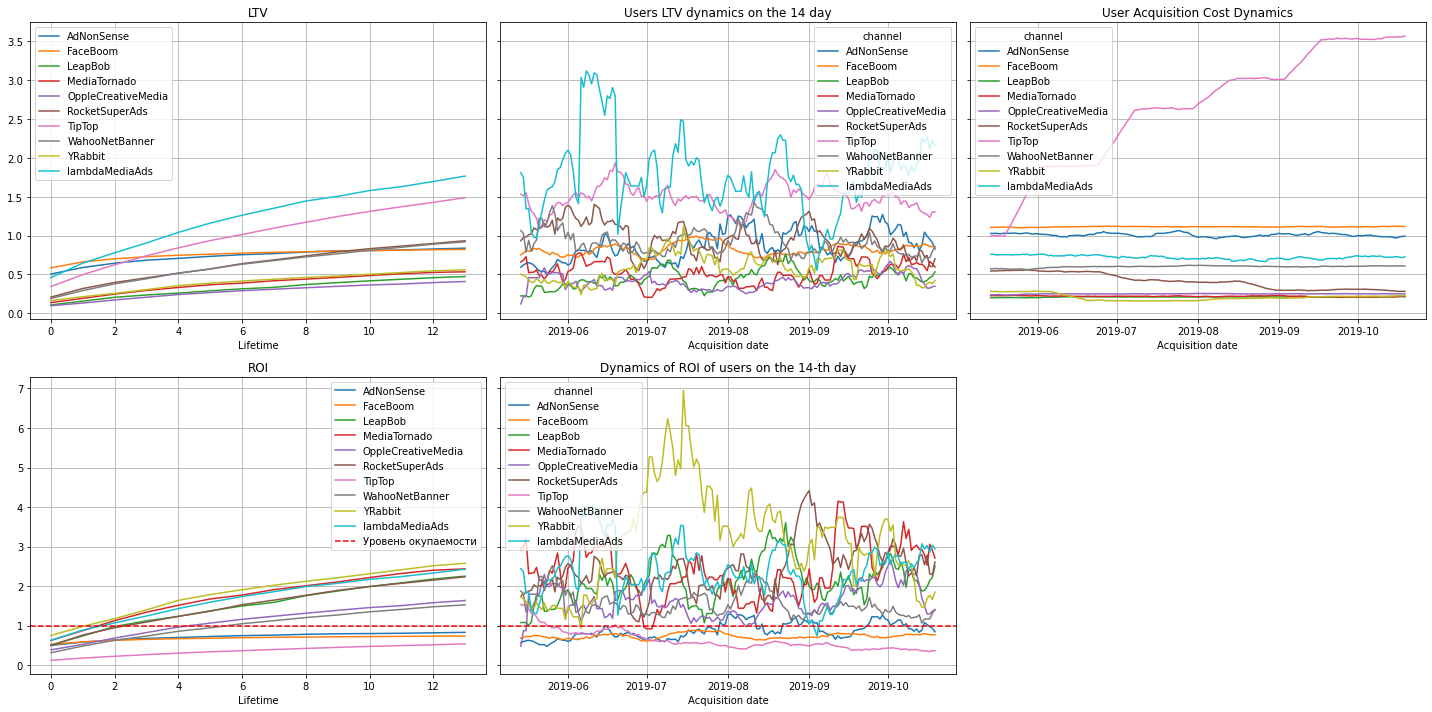

In [37]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Summary:
1. According to the two lower graphs, there are three channels for which the payback threshold has not been overcome (which most likely affect the overall payback) - these are `TipTop`, `FaceBoom` and `AdNonSense`. These three advertising channels also bring the least paying customers. And as we know, TipTop and Facebook are the most expensive channels for an application, especially TipTop.

2. Comparing the graphs of LTV and CAC dynamics, you can see that at the time of increasing the budget for the TipTop channel, LTV increases, but after a while it drops significantly.

3. The graph of LTV also highlights the `lambdaMediaAds`, which has the highest LTV, and the dynamics of highly varying LTV. It can be assumed that this advertising channel attracts a certain group of users of schoolchildren / students, since there is an increase in session time and a decline in early September, after which there is a high growth.

<a id="region_return"></a>
### Return on advertising by countries

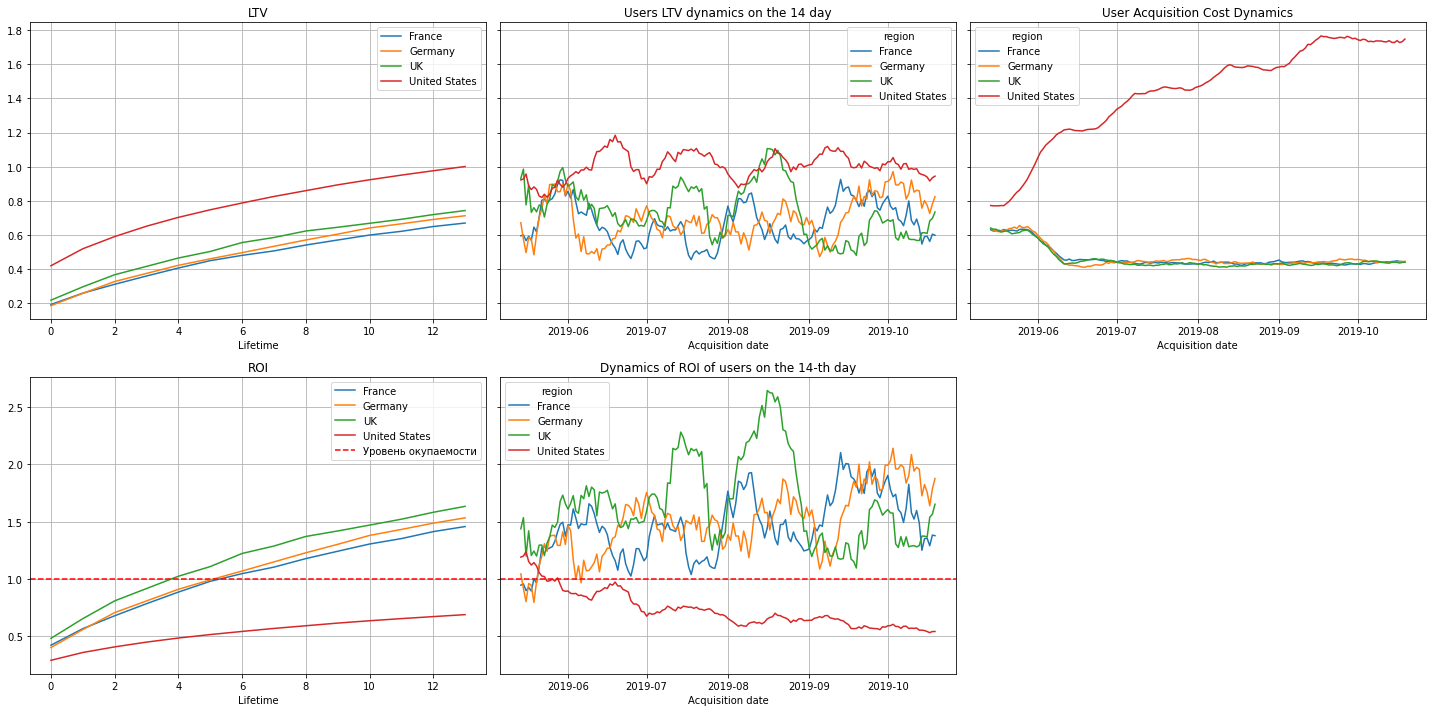

In [38]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Summary:
1. It is very interesting that the growth of CAC in the USA coincides with the TipTop channel. Apparently, the emphasis was on active advertising to the "USA" region through the TipTop platform
2. However, advertising in the USA does not pay off. ROI at the end of the second week is about 90%. The payback drop is approximately the end of July, as is the general ROI. It turns out that due to significant investments in advertising in Tip Top for the USA in early July, at the end of July, advertising in this region stopped paying off. 
3. LTV dynamics between regions does not differ much

<a id="sum_return"></a>
### Summary:
1. The payback of the entire project is low for the reason that large costs were invested in advertising in TipTop in the USA, however, a large number of paying users did not come from the TipTop platform.
2. It is worth reviewing advertising on TipTop, FaceBoom and AdNonSense platforms
3. The quality of users does not deteriorate
4. There may be a technical problem, as iOS devices stand out among all devices (there is no payback among them and CAC growth is strongest)

<a id="conversion_retention"></a>
## Conversion and retention

<a id="device_conversion_retention"></a>
### Conversion and retention by devices

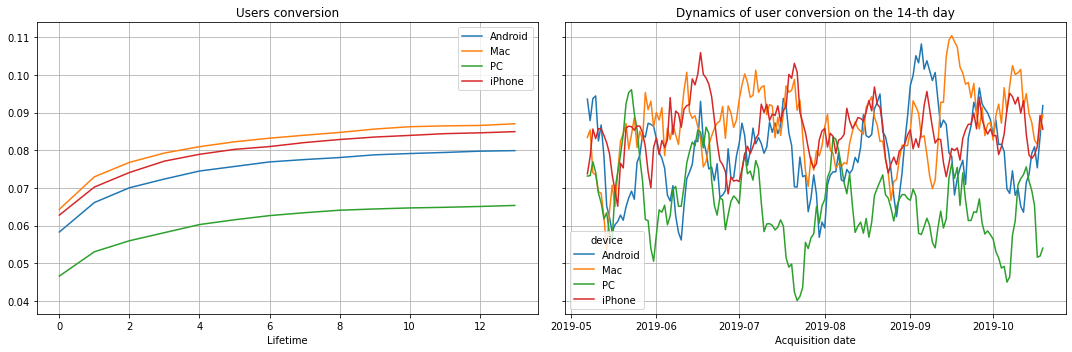

In [39]:
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

By the charts, iPhone and Mac users are converting very well. The conversion rate of PC users is lower than the rest, but among them the most paying.

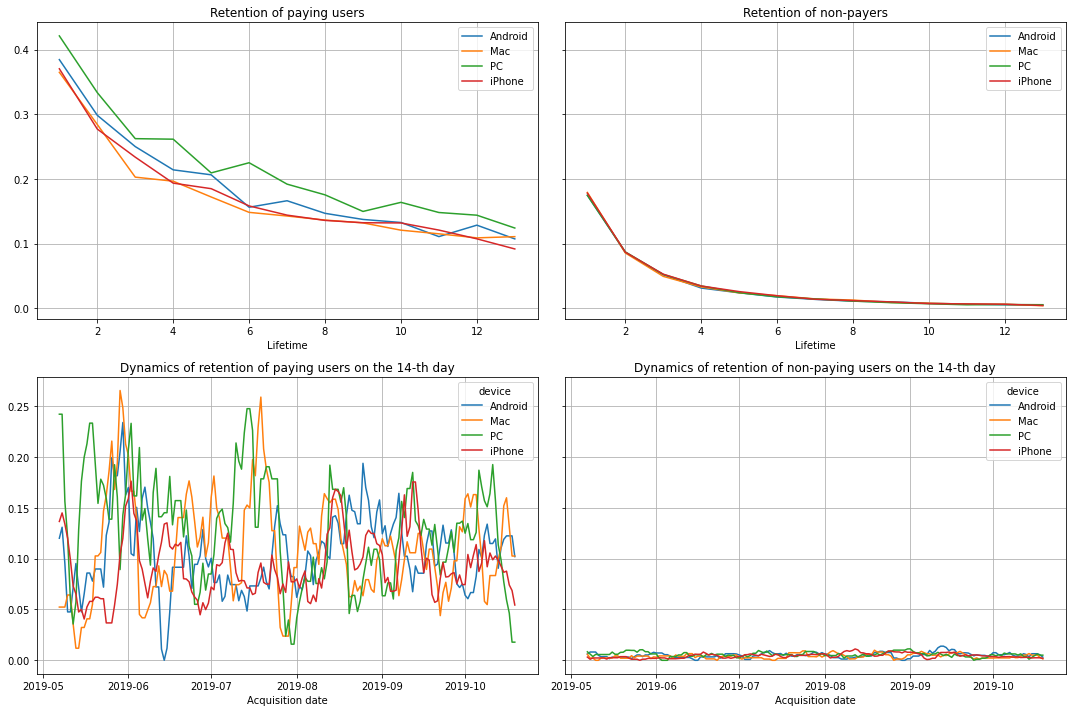

In [40]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Users are insufficiently retained after 2 days, paying iPhone and Mac users are worse than the rest. In general, it cannot be said that conversion and retention differ greatly from device to device

<a id="region_conversion_retention"></a>
### Conversion and retention by countries

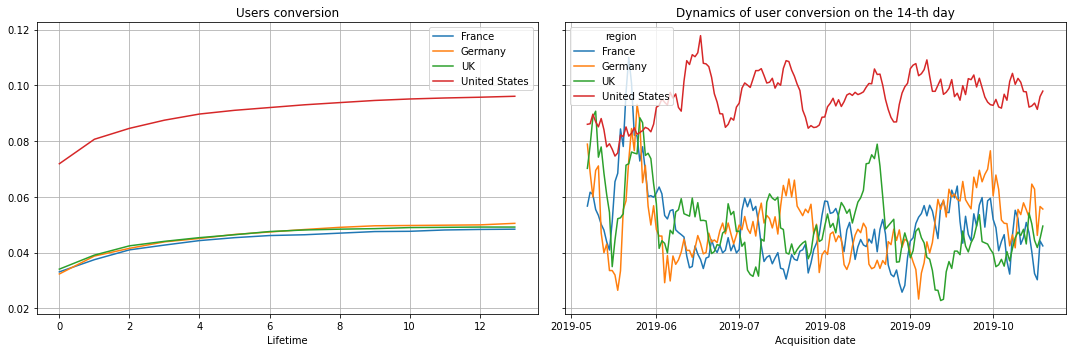

In [41]:
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

According to the graph, we see that users from the USA are converting very well compared to other countries, and constantly. Consider bad retention in USA, according to previous charts, things in the USA are not so good.

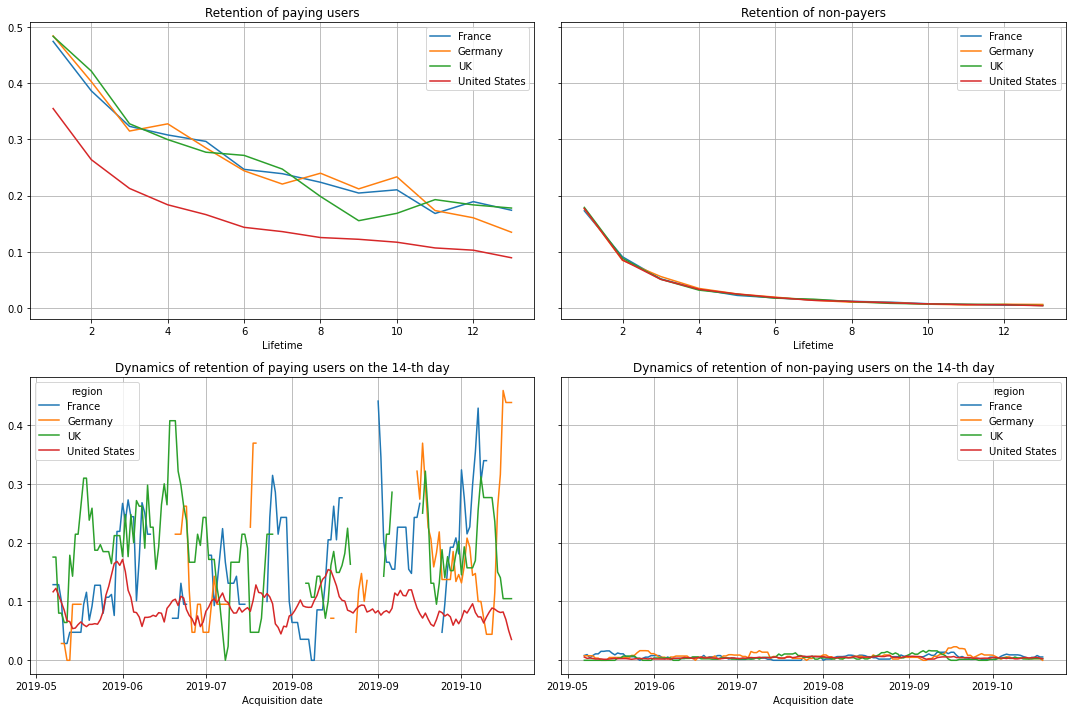

In [42]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Users from the USA, as we can see, are consistently insufficiently retained. For paying users on the iPhone, the retention of the 14th day is lower than on other devices by about 10%. The dynamics also show the low retention of paying users from the USA.

It can be assumed that the matter is in the channel through which users from the USA are attracted

<a id="channel_conversion_retention"></a>
### Conversion and retention by ad channels

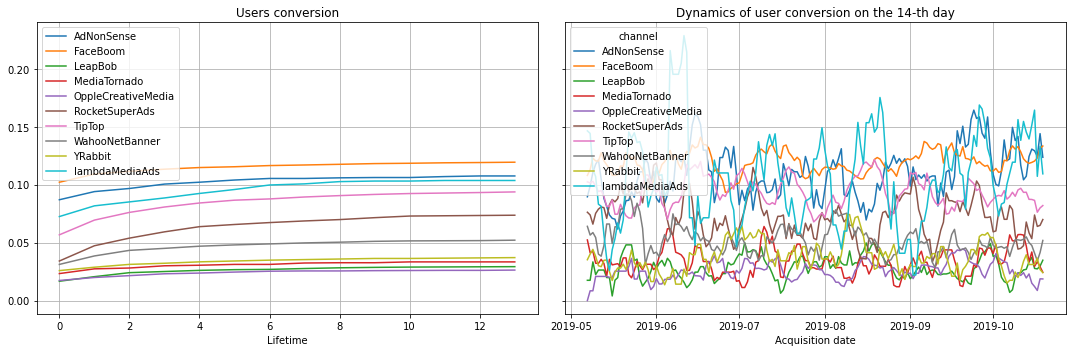

In [43]:
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

According to the conversion graph, we see that the FaceBoom advertising channel converts users quite well, the TipTop channel also has not the lowest conversion rate

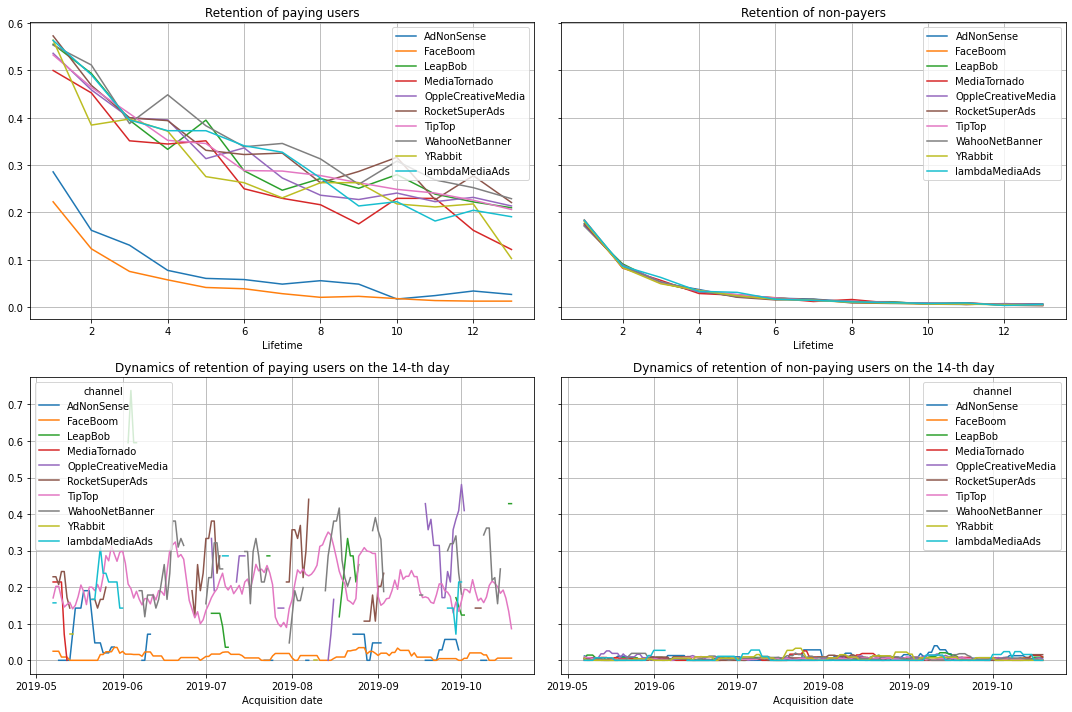

In [44]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

According to the first graph, it becomes clear that paying users from FaceBoom and AdNonSense channels are consistently insufficiently retained. At the same time, the Tip Top channel has average indicators.

As for the dynamics, we see that some advertising channels in general did not "bring" paying customers, but FaceBoom's low indicators are especially noticeable.

Ответим на вопросы:
1. **Does advertising pay off in general?**
All charts show that advertising does not pay off: low ROI, a fairly strong drop across all platforms, countries and channels of paying customers for about 2-3 days.

2. **Which devices, countries and channels can reduce the payback of advertising?**
Based on the graphs, we can say that the fact that the user has an iPhone or Mac affects; the country of residence of the USA also affects; and also affects which channels are attracted - FaceBoom and AdNonSense have the lowest indicators

3. **What can cause return on ad cost problems?**
* too much costs for certain channels (FaceBoom), which do not bring a relatively large number of paying users
* costs for a certain country, from which a large number of paying customers do not come
* technical problems, as for all "factors" (country, device, advertising channel) retention decreases on the second or third day of life time

#### Possible causes of the detected problems and recommendations for the marketing department
1. Causes:
* problems with FaceBoom and AdNonSense advertising channels
* technical problems on the part of the application (the decrease in iPhone and Mac is slightly stronger than the rest)

2. Recommendations:
* additional analysis of advertising campaigns in FaceBoom, AdNonSense and TipTop advertising channels for paying users by name
* promotions, bonuses, discounts for 2-3 days of use, since during this period there is a strong decline in retention

<a id="conclusion"></a>
## Conclusion

### Reasons for inefficiency in attracting users

1. Advertising in the USA does not pay off - despite the fact that the largest percentage of paying users. Possible reasons for the problem of **low retention** of this audience, as well as an **increase CAC**
2. Problems with the TipTop channel are associated with a strong increase in CAC, which affected the drop in payback
3. On the FaceBoom channel, you can say that there is a problem with retention. The same kind of problem with the AdNonSense channel
4. The problem of low payback on iOS devices is associated with a decrease in retention on iPhone and Mac

### Recommendations for the marketing department

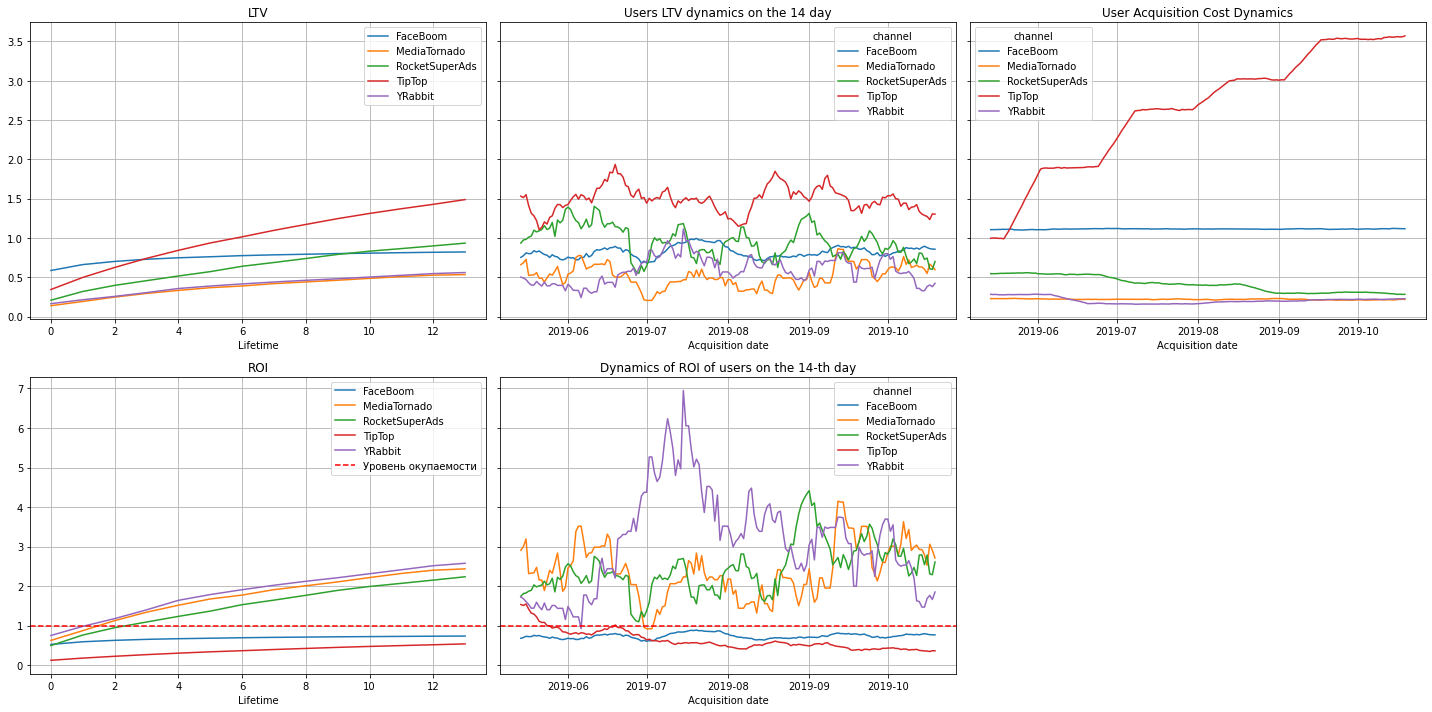

In [45]:
dimensions = ['channel']
profiles_usa = profiles[profiles['region'] == 'United States']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

It is clear that FaceBoom and TipTop do not pay off, since the CAC on them is higher, and on TipTop it is also unstable. According to the payback dynamics schedule, the YRabbit channel is standed out, as well as MediaTornado

Recommendations:
1. In order to optimize advertising costs in the USA, it is worth spending more money on YRabbit and MediaTornado channels. Also, LTV TipTop is high, so it may be worth reducing the ad costs of this channel
2. Consider the option with promotions, bonuses, discounts, etc. for 2-3 days of use, since during this period there is a strong decline in retention
3. In Europe, it is worth increasing advertising spending among residents of the UK and France (they have higher retention than others), which will increase conversion
4. For devices, it is worth paying attention to PC users who have higher retention than the rest (but it drops significantly on day 14), as well as the only ones at the end of the second week payback comes
5. Retention has been decreasing for all advertising channels since 3 days, but you can work with WahooNetBanner and RocketSuperAds channels, whose retention is slightly higher than the rest, and also spend more on YRabbit and MediaTornado channels with the largest ROI